In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from sklearn.model_selection import train_test_split


from stardist import fill_label_holes, _draw_polygons, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

/tmp/ipykernel_7090/3904132788.py:5: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None


In [2]:
import logging
logger = logging.getLogger()  # Logger

logger.setLevel("INFO")
#logging.info("Hello")

In [3]:
import pickle
def write_pickle(path, obj):
    with open(path, "wb") as f:
        pickle.dump(obj, f)
        
def read_pickle(path):
    with open(path, "rb") as f:
        obj = pickle.load(f)
    return obj

In [ ]:
img_dict = read_pickle(path="/mnt/DataRAID/melismail/Preprocessing/data/pickle_data/Preprocessing/img_dict_scaled.pkl")
mask_dict = read_pickle(path="/mnt/DataRAID/melismail/Preprocessing/data/pickle_data/Preprocessing/mask_dict_scaled.pkl")

In [5]:
img_list = list(img_dict.values())
mask_list = list(mask_dict.values())

In [6]:
#img_list = list(img_dict.values())
#mask_list = list(mask_dict.values())
print(len(img_list))
print(len(mask_list))

24244
24244


In [7]:
print(img_list[1245].shape)

(512, 512, 3)


In [8]:
print(mask_list[1245].shape)

(512, 512)


In [9]:
# split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(img_list, mask_list, test_size=0.10, random_state=42)

In [11]:
write_pickle(path="/mnt/DataRAID/melismail/Preprocessing/data/pickle_data/Stardist/5.Run/X_train.pkl", obj=X_train)
write_pickle(path="/mnt/DataRAID/melismail/Preprocessing/data/pickle_data/Stardist/5.Run/y_train.pkl", obj=y_train)
write_pickle(path="/mnt/DataRAID/melismail/Preprocessing/data/pickle_data/Stardist/5.Run/X_test.pkl", obj=X_test)
write_pickle(path="/mnt/DataRAID/melismail/Preprocessing/data/pickle_data/Stardist/5.Run/y_test.pkl", obj=y_test)

In [8]:
X_train = read_pickle(path="/mnt/DataRAID/melismail/Preprocessing/data/pickle_data/Stardist/4.Run/X_train.pkl")
y_train = read_pickle(path="/mnt/DataRAID/melismail/Preprocessing/data/pickle_data/Stardist/4.Run/X_train.pkl")
X_test = read_pickle(path="/mnt/DataRAID/melismail/Preprocessing/data/pickle_data/Stardist/4.Run/X_test.pkl")
y_test = read_pickle(path="/mnt/DataRAID/melismail/Preprocessing/data/pickle_data/Stardist/4.Run/y_test.pkl")

In [9]:
X = X_train
Y = y_train

In [11]:
n_channel = 3 if X[0].ndim == 2 else X[0].shape[-1]

In [ ]:
#axis_norm = (0,1)   # normalize channels independently
axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

In [ ]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

In [ ]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(20,15), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap='gray')
    al.set_title(lbl_title)
    plt.tight_layout()

In [ ]:
i = min(12582, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

In [ ]:
print(Config2D.__doc__)

In [26]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [28]:
#if use_gpu
from csbdeep.utils.tf import limit_gpu_memory
# adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
#limit_gpu_memory(0.8)
# alternatively, try this:
limit_gpu_memory(None, allow_growth=True)

In [29]:
model = StarDist2D(conf, name='5_run', basedir='models')

2022-08-02 01:18:27.993207: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 01:18:30.794360: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30988 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:65:00.0, compute capability: 7.0


Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [30]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

2022-08-02 01:19:22.372591: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-08-02 01:19:33.711527: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-02 01:19:33.719070: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-02 01:19:33.719151: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-02 01:19:33.735513: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-02 01:19:33.735681: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


median object size:      [0. 0.]
network field of view :  [94 94]


In [31]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


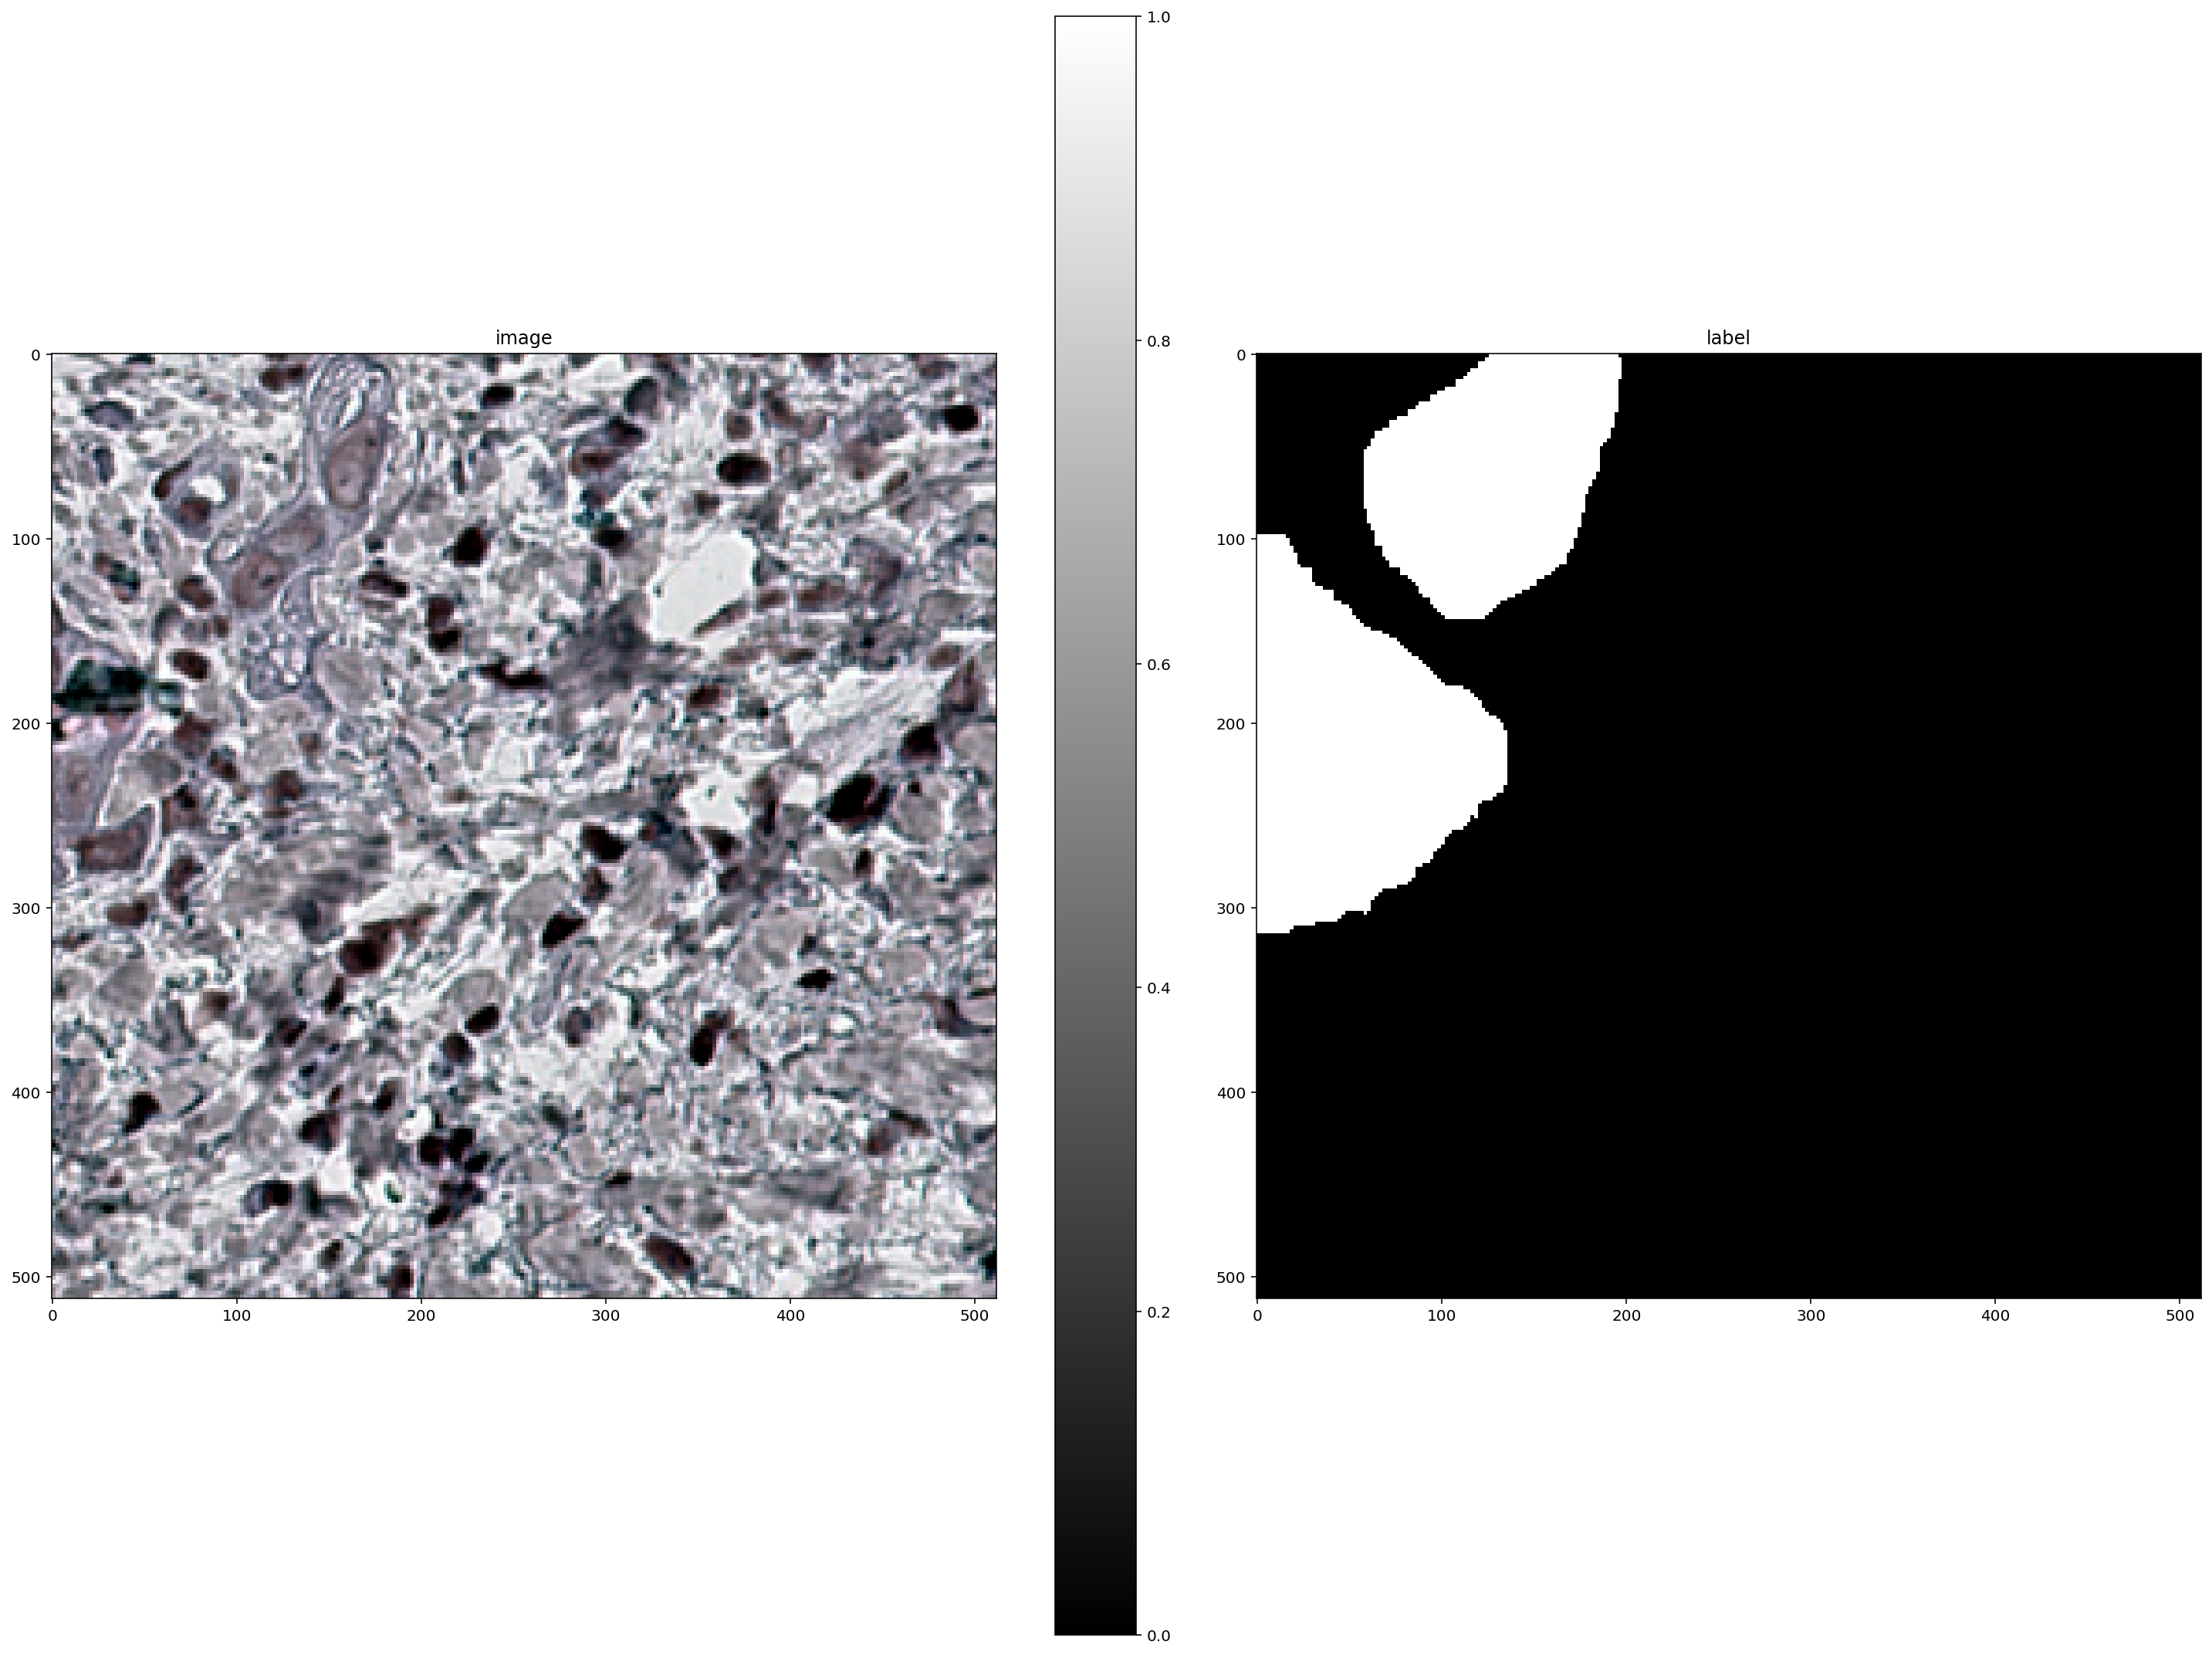

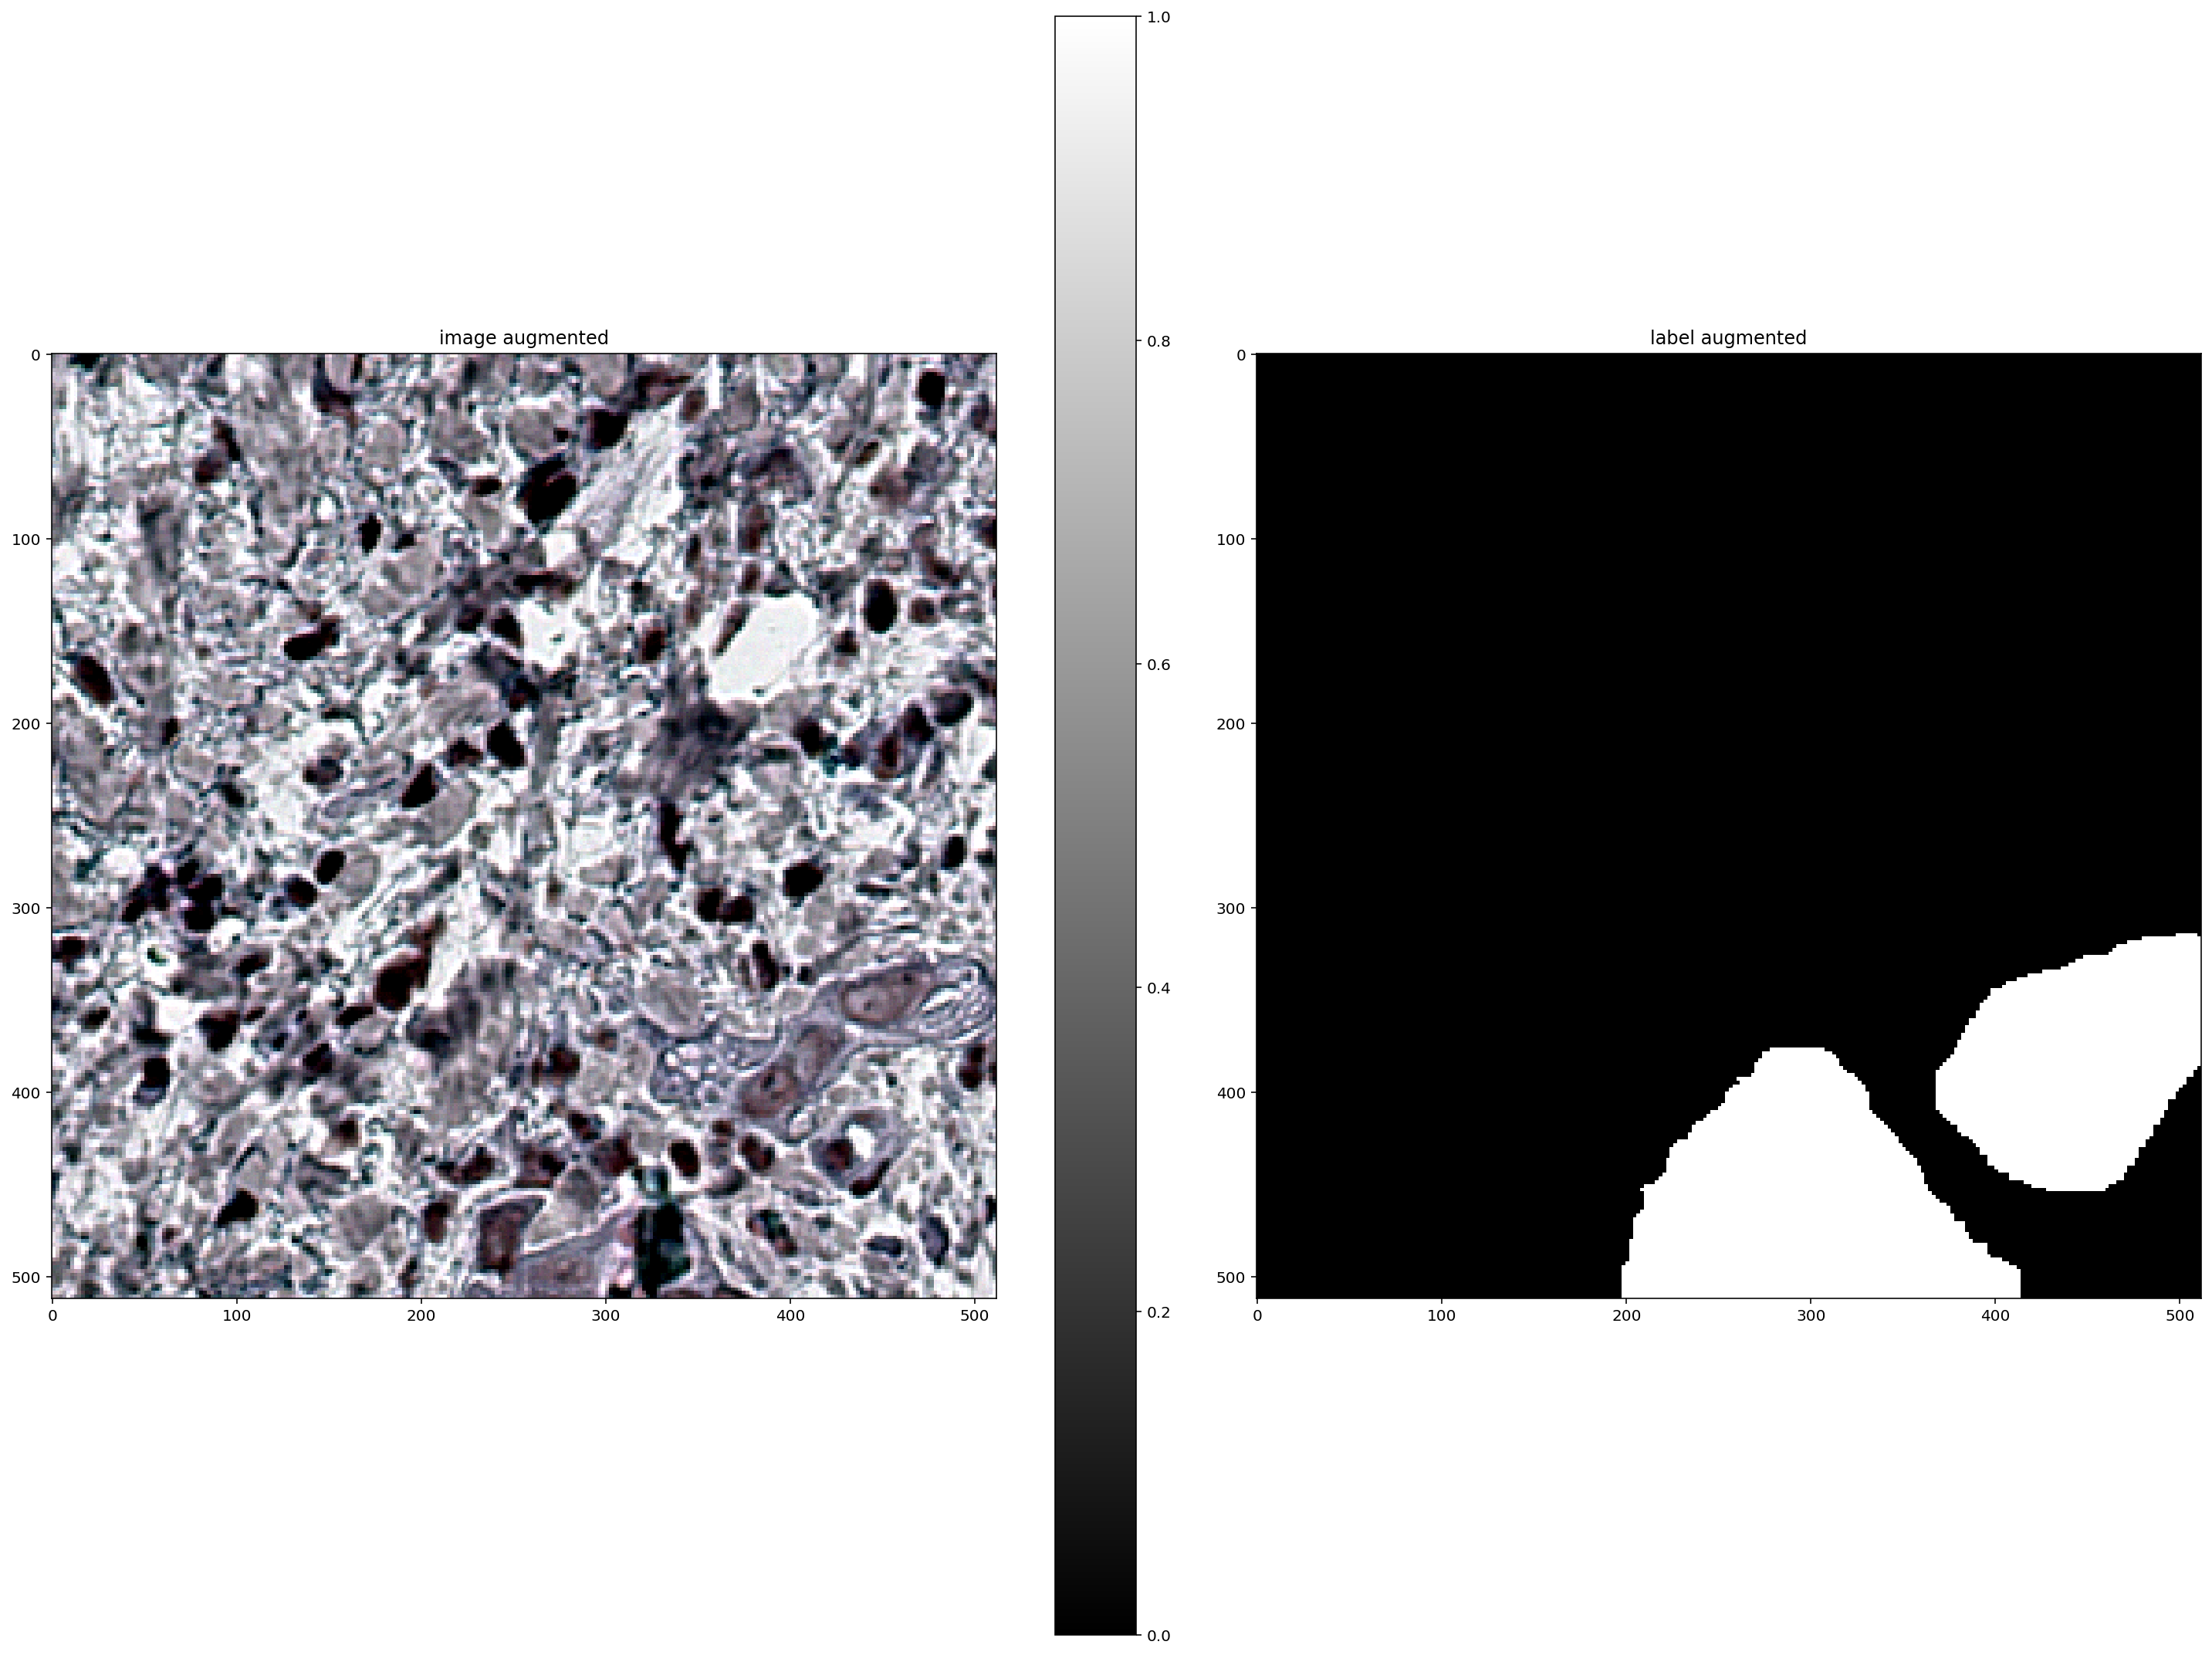

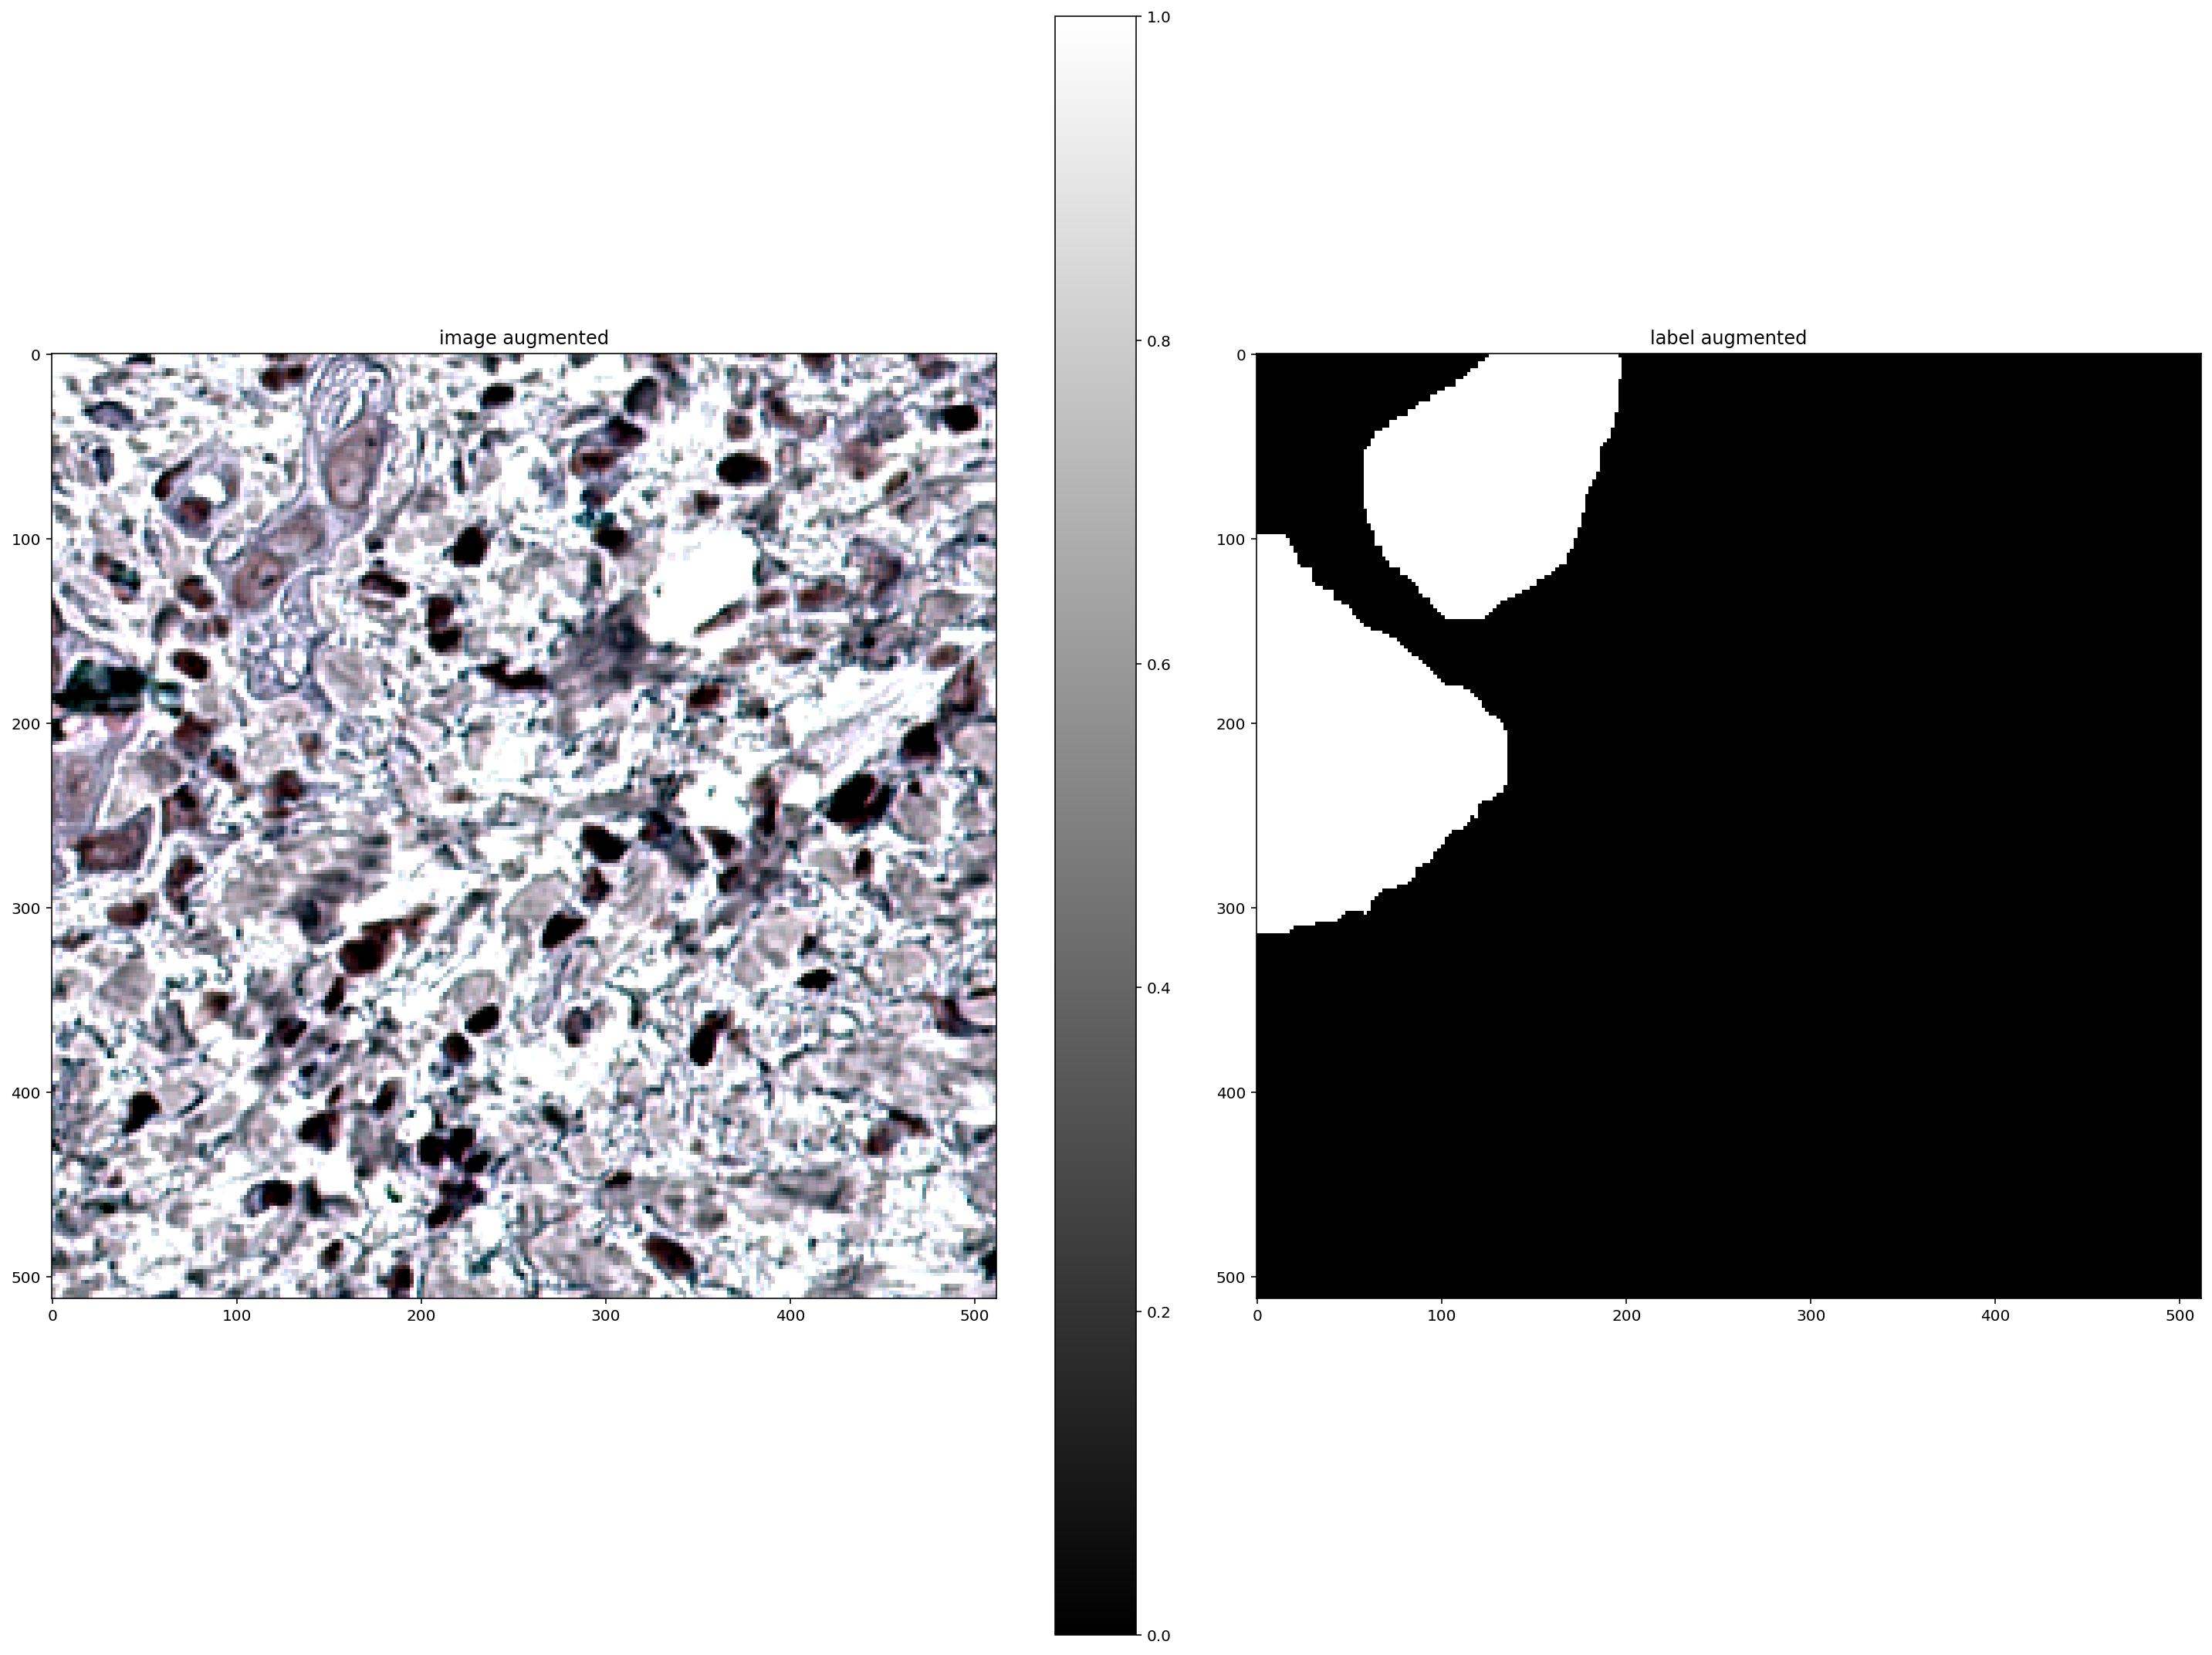

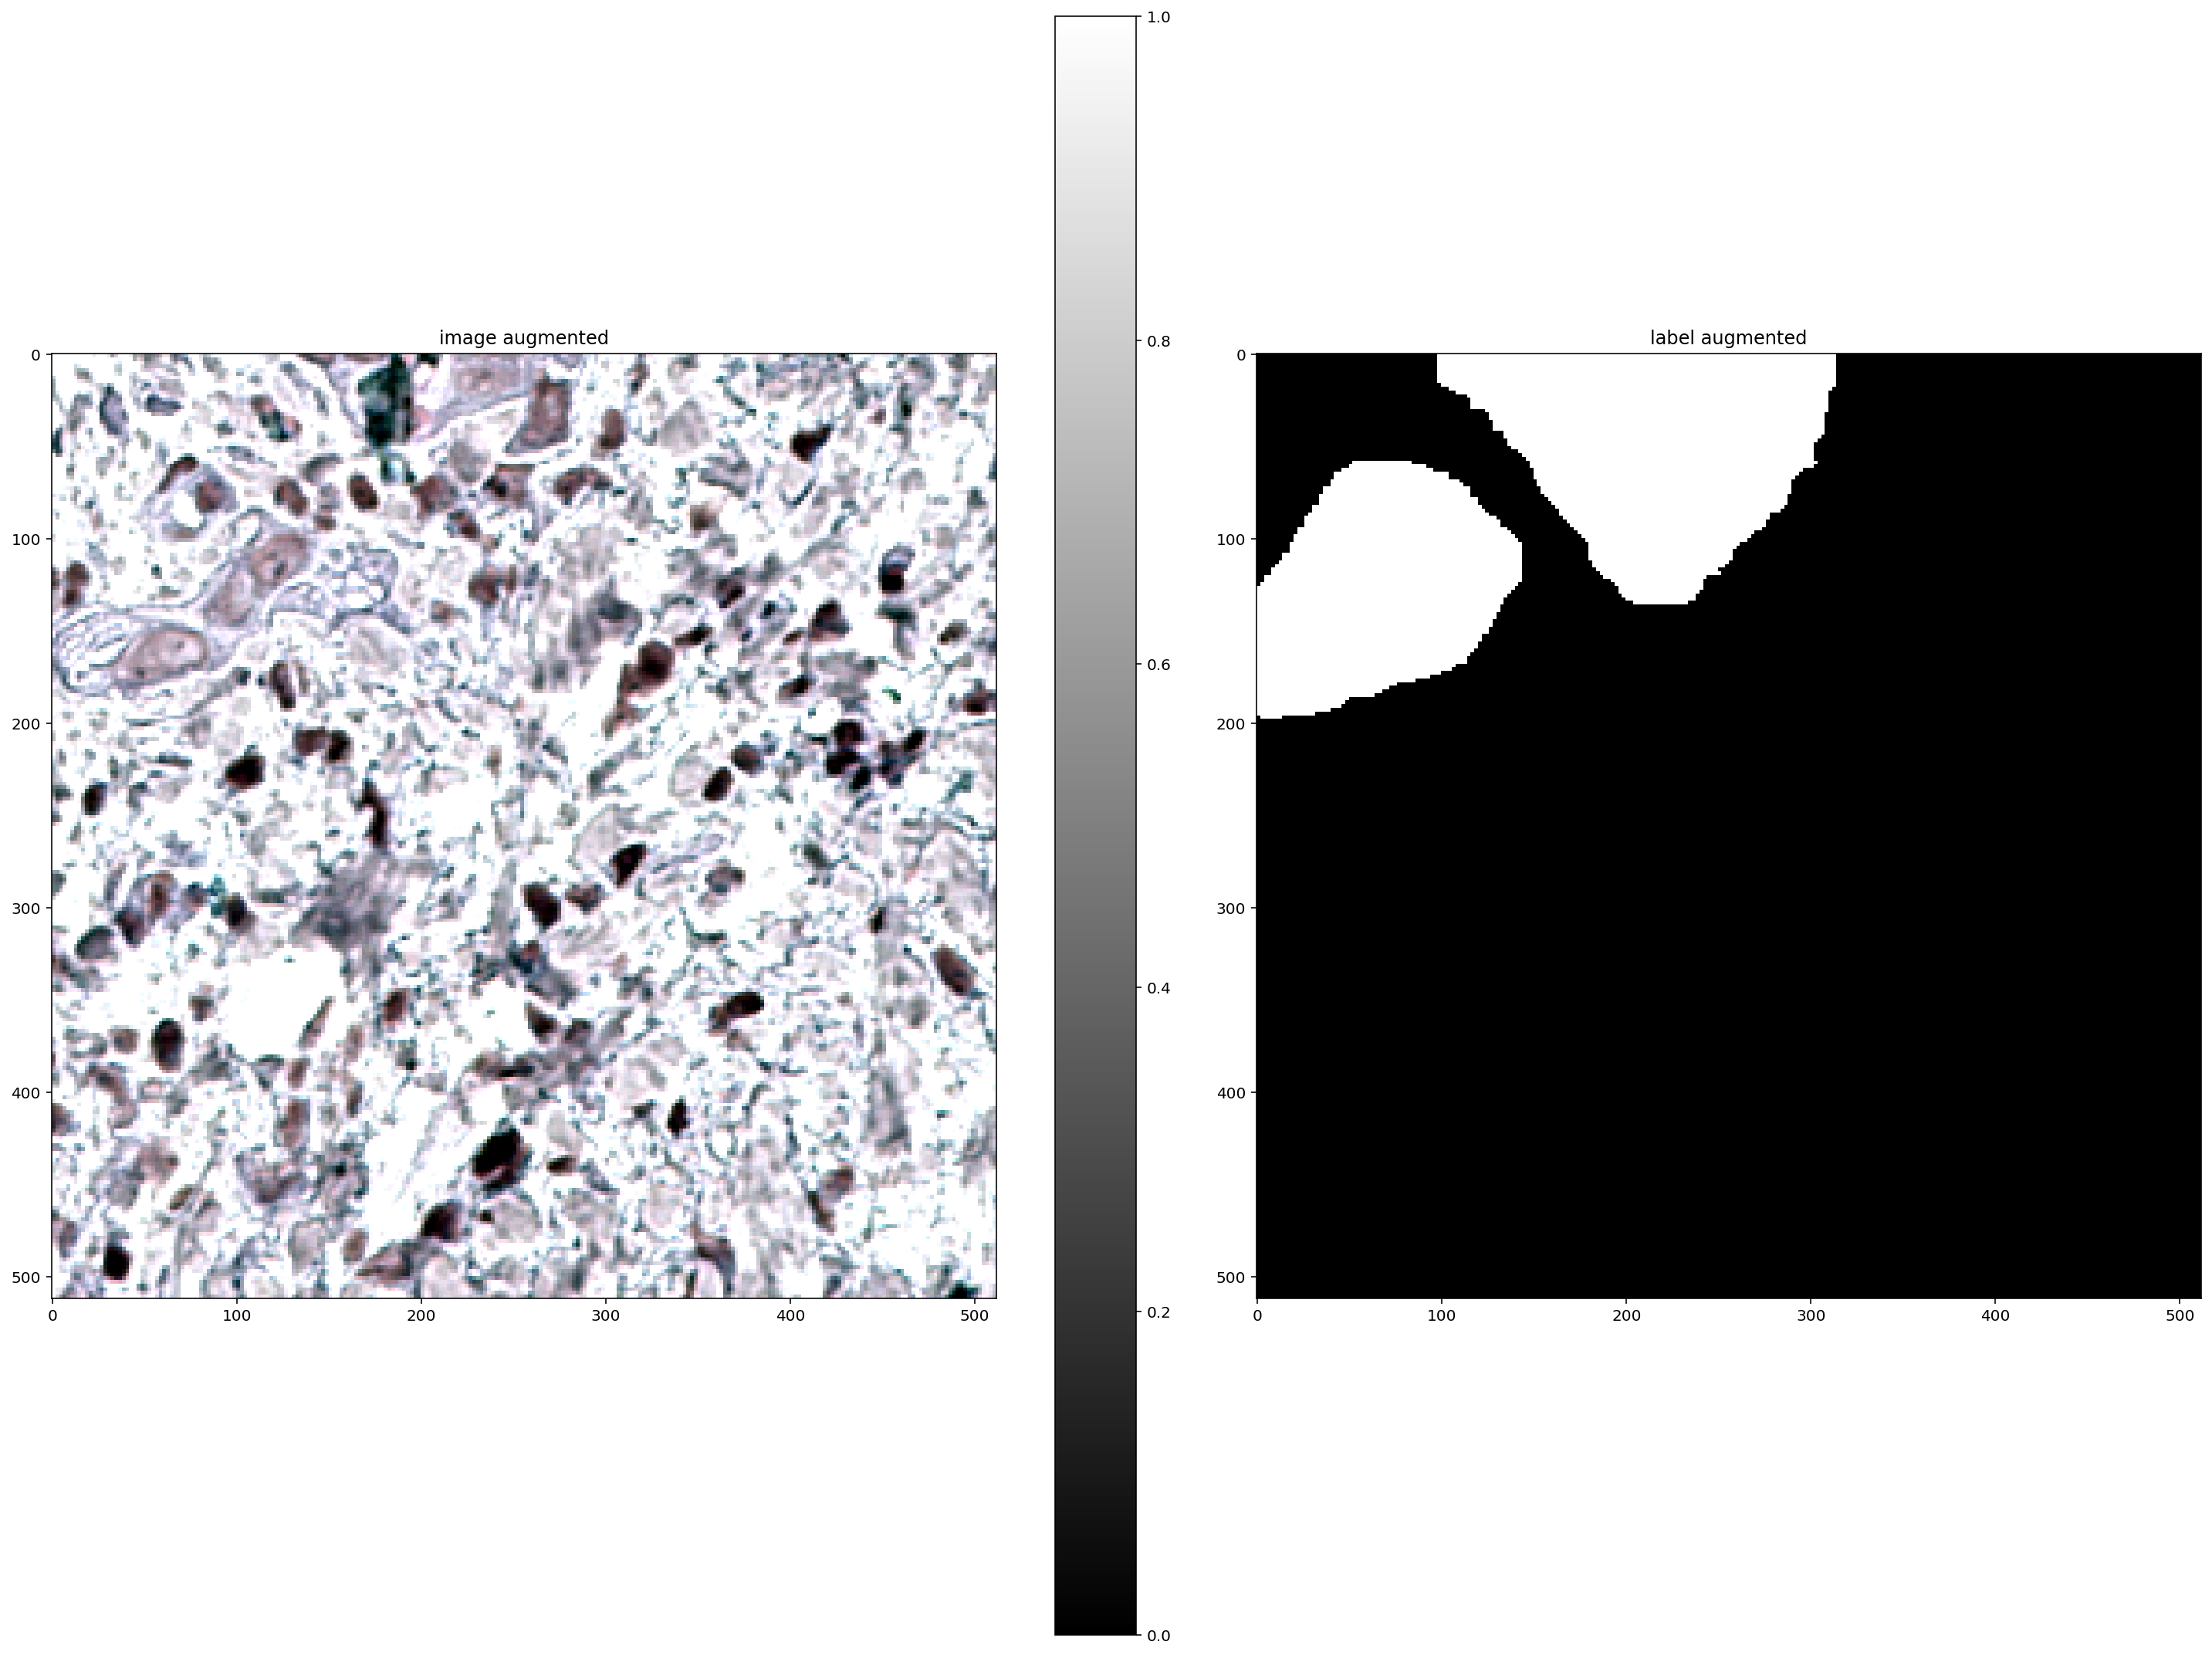

In [32]:
# plot some augmented examples
img, lbl = X[12582],Y[12582]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

In [ ]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=10)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist2D.from_pretrained('2D_versatile_he')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

Epoch 1/200
200/200 [==============================] - 112s 528ms/step - loss: 6.9309 - prob_loss: 0.1573 - dist_loss: 67.7352 - prob_kld: 0.1241 - dist_relevant_mae: 67.7247 - dist_relevant_mse: 12845.5840 - dist_dist_iou_metric: 0.1974 - val_loss: 0.0035 - val_prob_loss: 0.0025 - val_dist_loss: 0.0103 - val_prob_kld: 0.0025 - val_dist_relevant_mae: 0.0000e+00 - val_dist_relevant_mse: 0.0000e+00 - val_dist_dist_iou_metric: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/200
200/200 [==============================] - 105s 527ms/step - loss: 6.4388 - prob_loss: 0.1367 - dist_loss: 63.0207 - prob_kld: 0.1049 - dist_relevant_mae: 63.0092 - dist_relevant_mse: 13139.6973 - dist_dist_iou_metric: 0.1794 - val_loss: 0.0155 - val_prob_loss: 0.0137 - val_dist_loss: 0.0177 - val_prob_kld: 0.0137 - val_dist_relevant_mae: 0.0000e+00 - val_dist_relevant_mse: 0.0000e+00 - val_dist_dist_iou_metric: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/200
200/200 [==============================] - 106s 533ms/step - loss: 6.2672 - 

In [6]:
# load trained mode
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist2D.from_pretrained('2D_versatile_he')
else:
    model = StarDist2D(None, name='4_run', basedir='models')
None;

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [7]:
if quick_demo:
    model.optimize_thresholds(X_val[:2], Y_val[:2])
else:
    model.optimize_thresholds(X_val, Y_val)

NameError: name 'X_val' is not defined

In [27]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|████████████████████████████████████████████████████████████████| 3273/3273 [03:13<00:00, 16.88it/s]


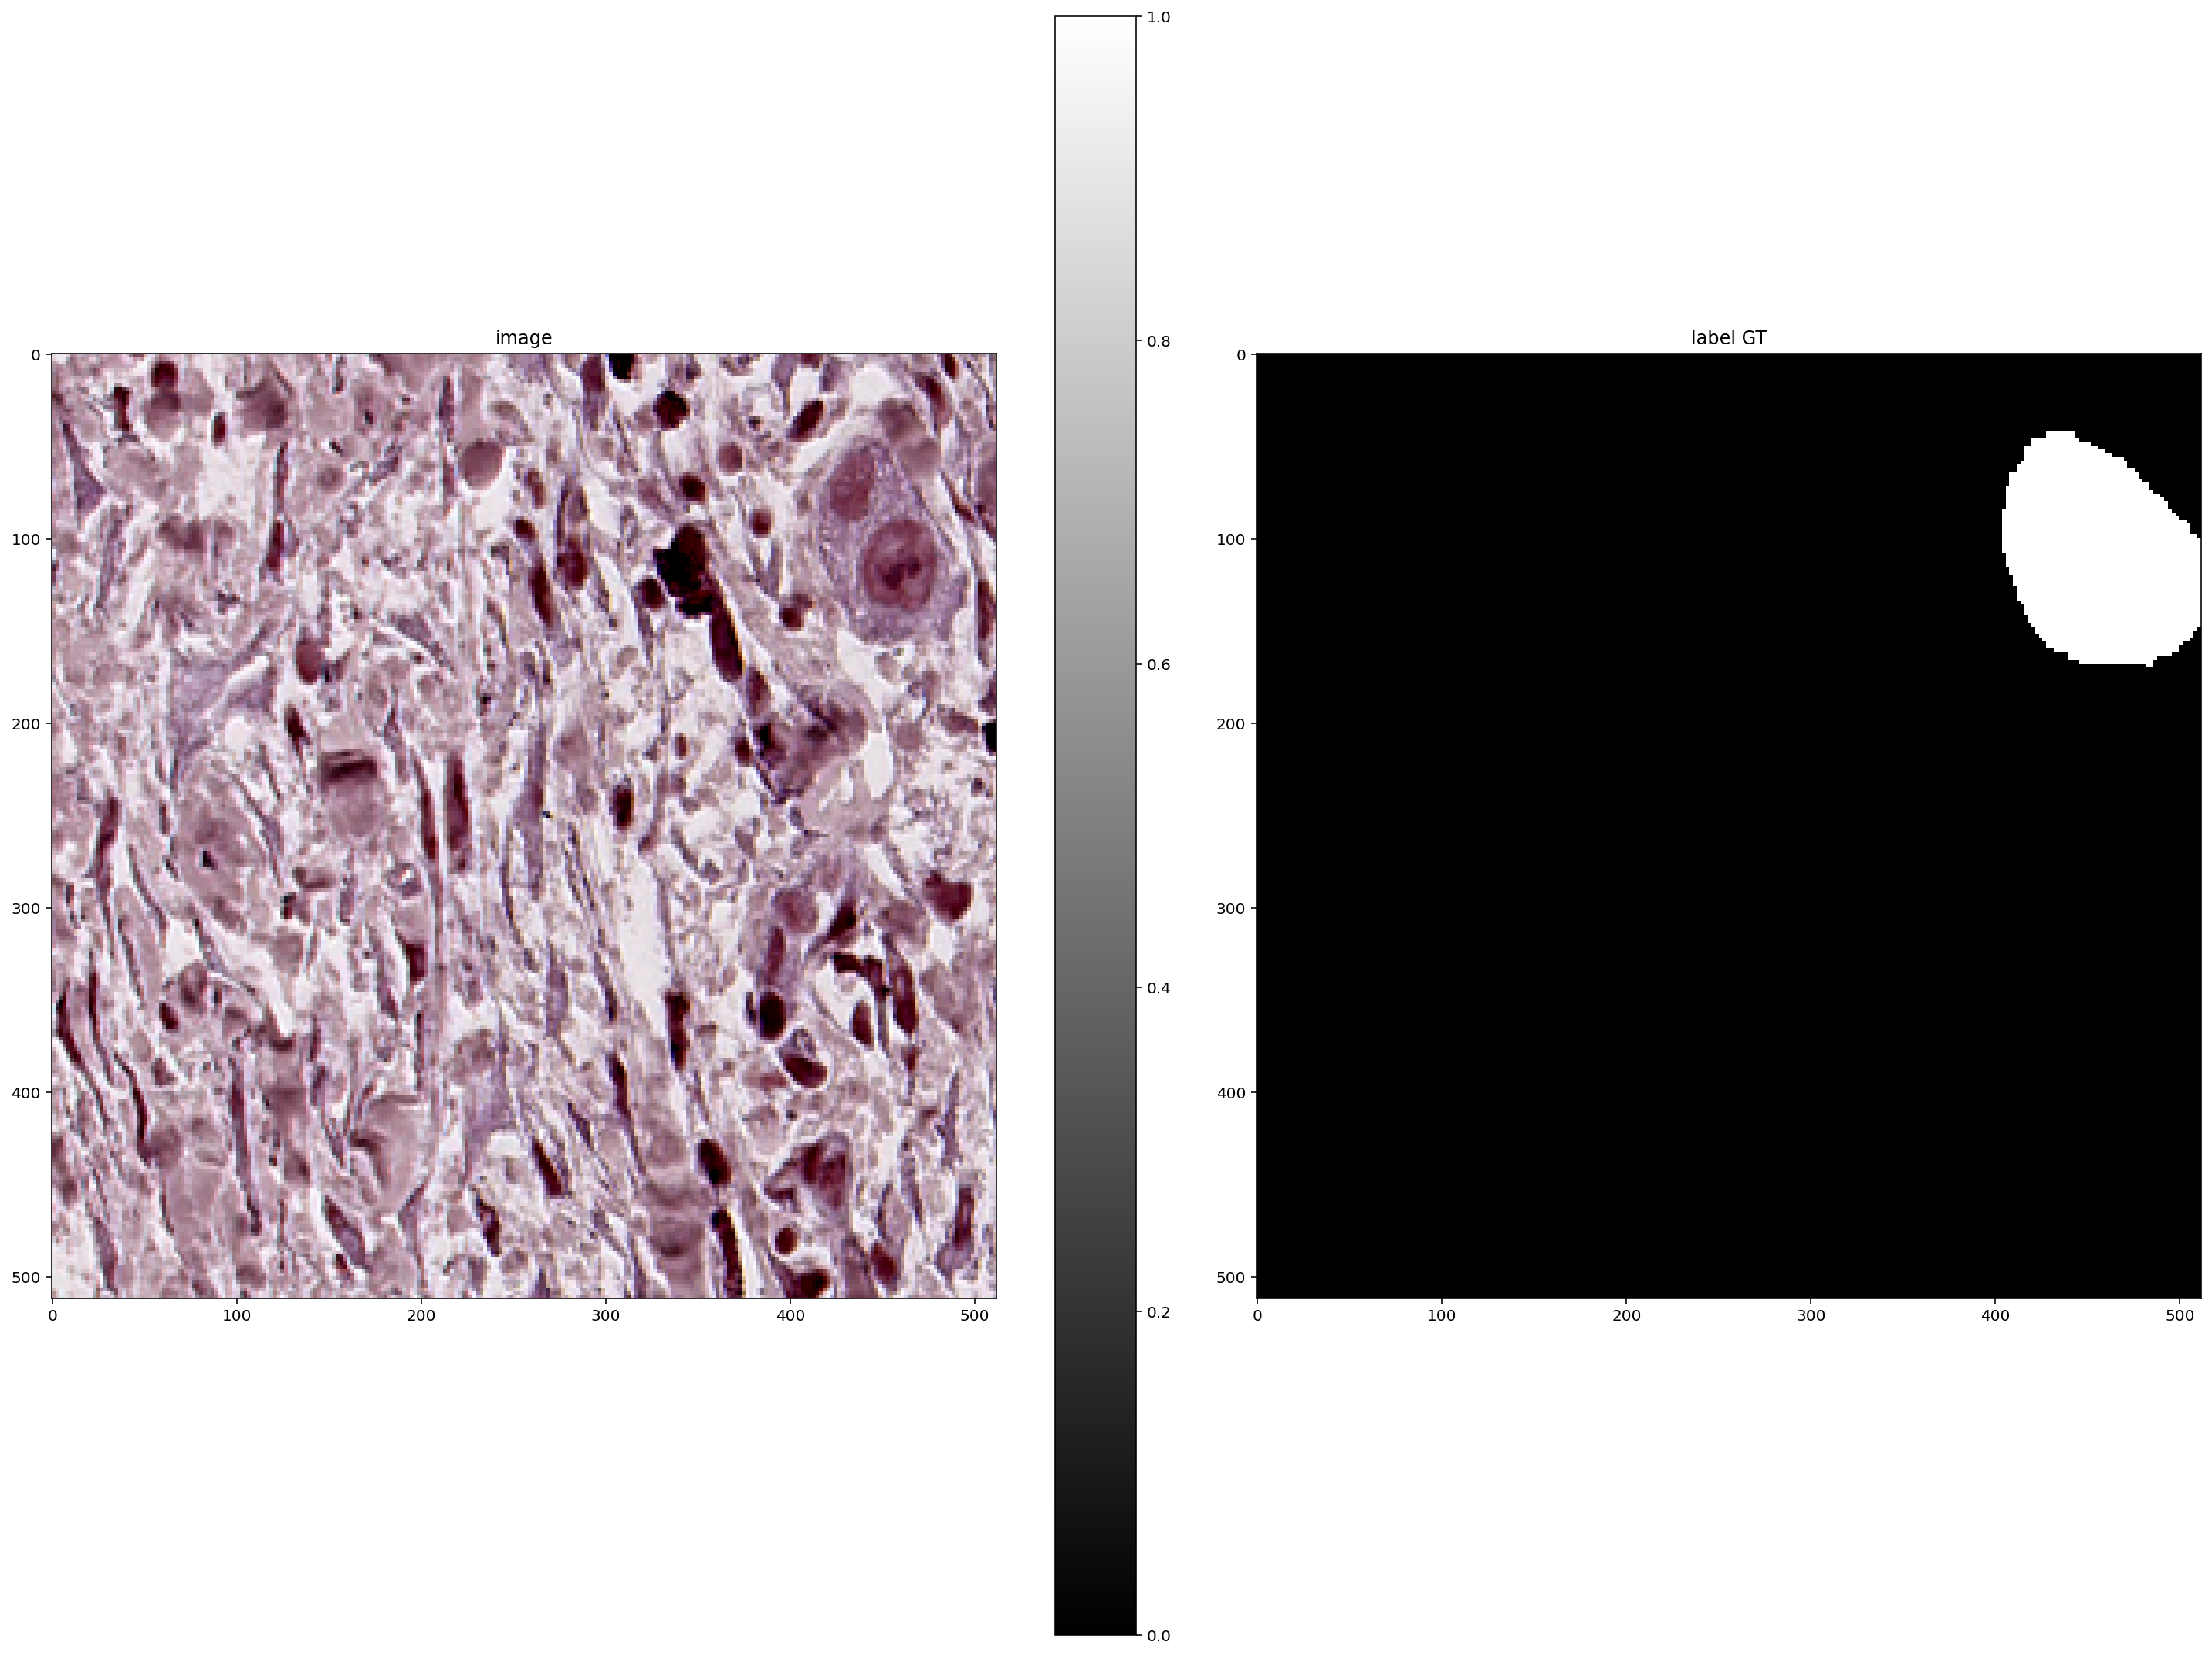

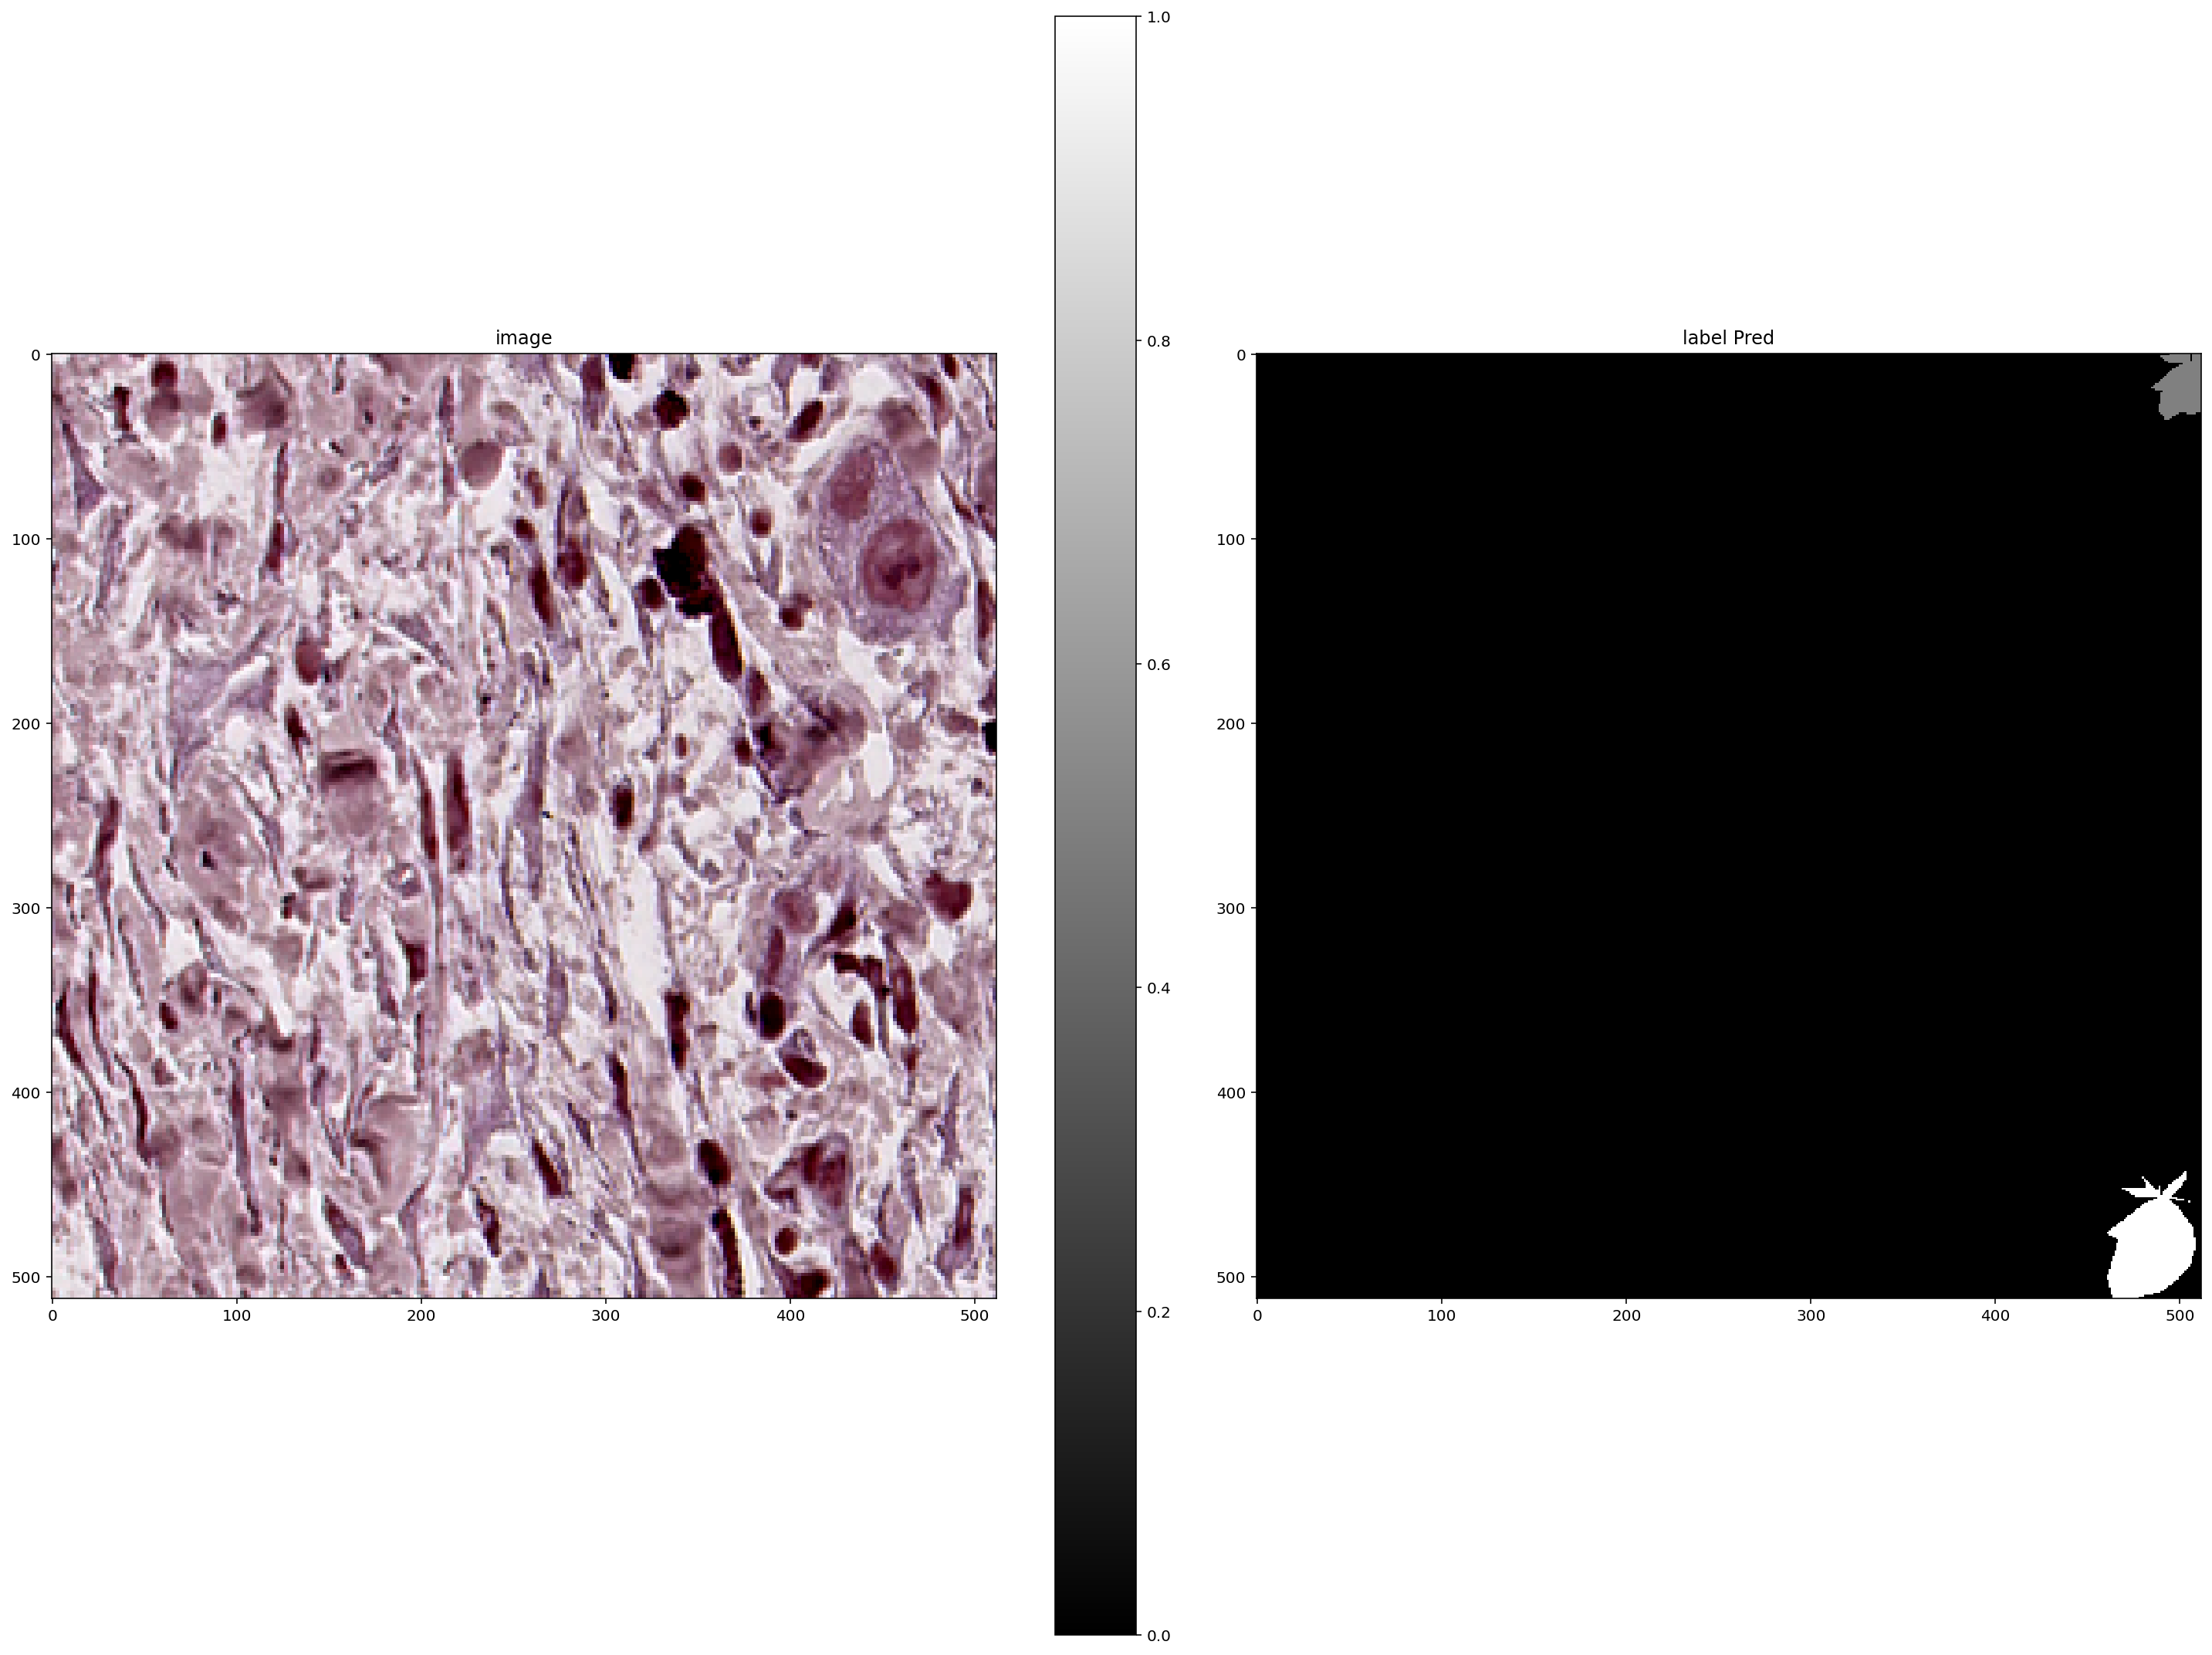

In [35]:
plot_img_label(X_val[3272],Y_val[3272], lbl_title="label GT")
plot_img_label(X_val[3272],Y_val_pred[3272], lbl_title="label Pred")

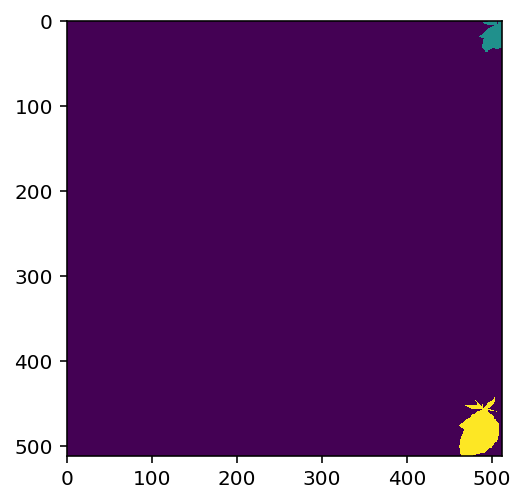

In [38]:
plt.imshow(Y_val_pred[3272])

In [36]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████████████████████████████████████████████████████████████████| 9/9 [03:48<00:00, 25.40s/it]


In [39]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=4706, tp=1, fn=530, precision=0.00021244954323348204, recall=0.0018832391713747645, accuracy=0.00019094901661256445, f1=0.00038182512409316535, n_true=531, n_pred=4707, mean_true_score=0.0009634179359550979, mean_matched_score=0.511574923992157, panoptic_quality=0.00019533215883625697, by_image=False)

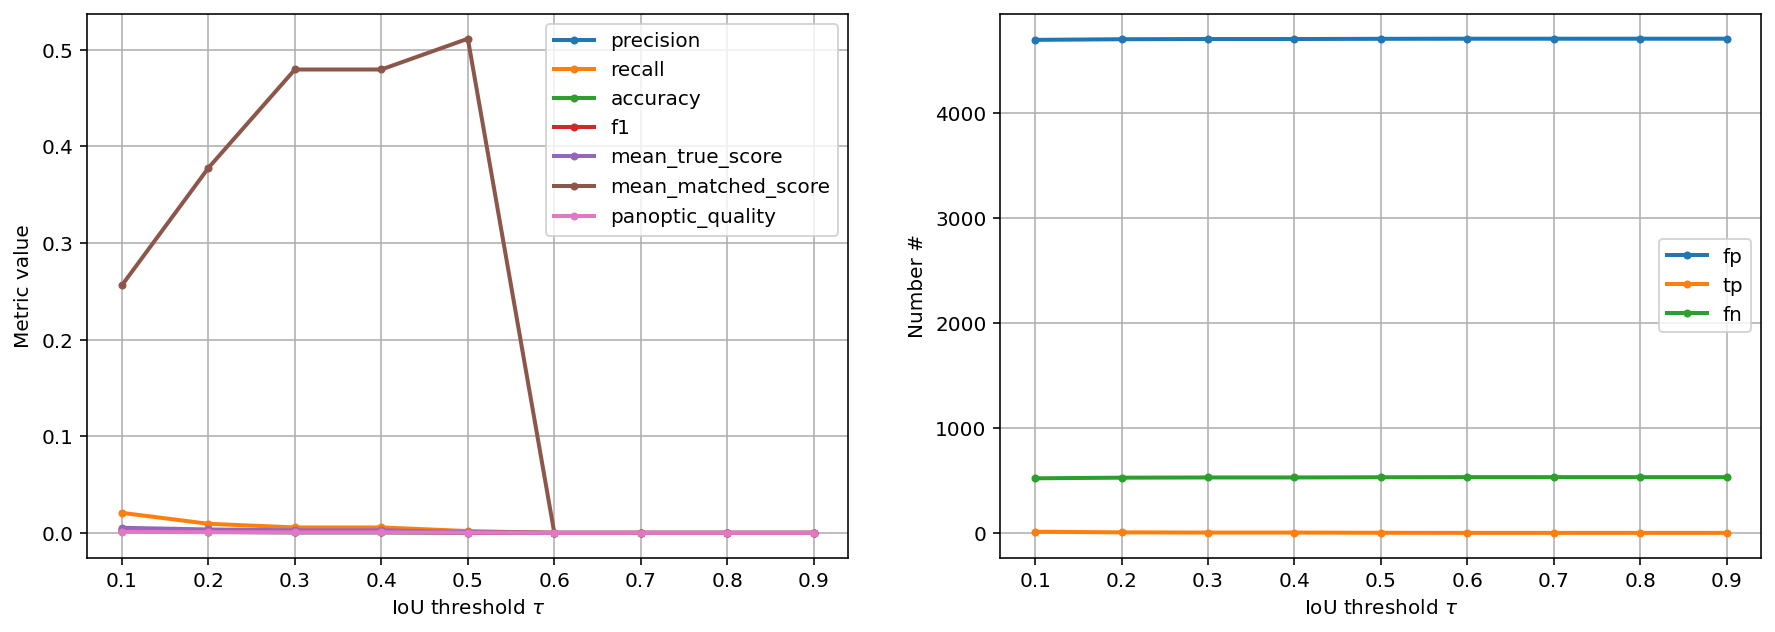

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [48]:
Xt = X_test
n_channel = 1 if Xt[0].ndim == 2 else Xt[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
#axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 3:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [49]:
# show all test images
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, Xt)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

In [51]:
img = normalize(Xt[34], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

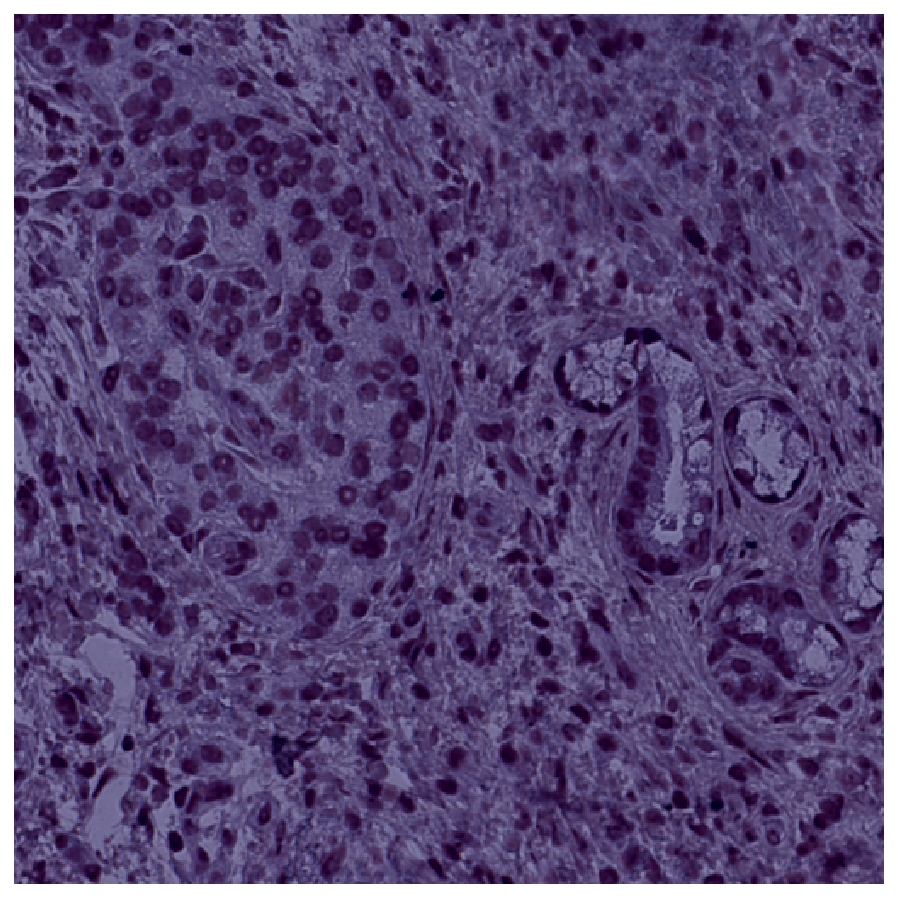

In [61]:
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==3 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap='seismic', alpha=0.5)
plt.axis('off');

In [74]:
def example(model, i, show_dist=True):
    img = normalize(Xt[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(20,15))
    img_show = img if img.ndim==3 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap='gray', alpha=0.5)
    plt.tight_layout()
    plt.show()

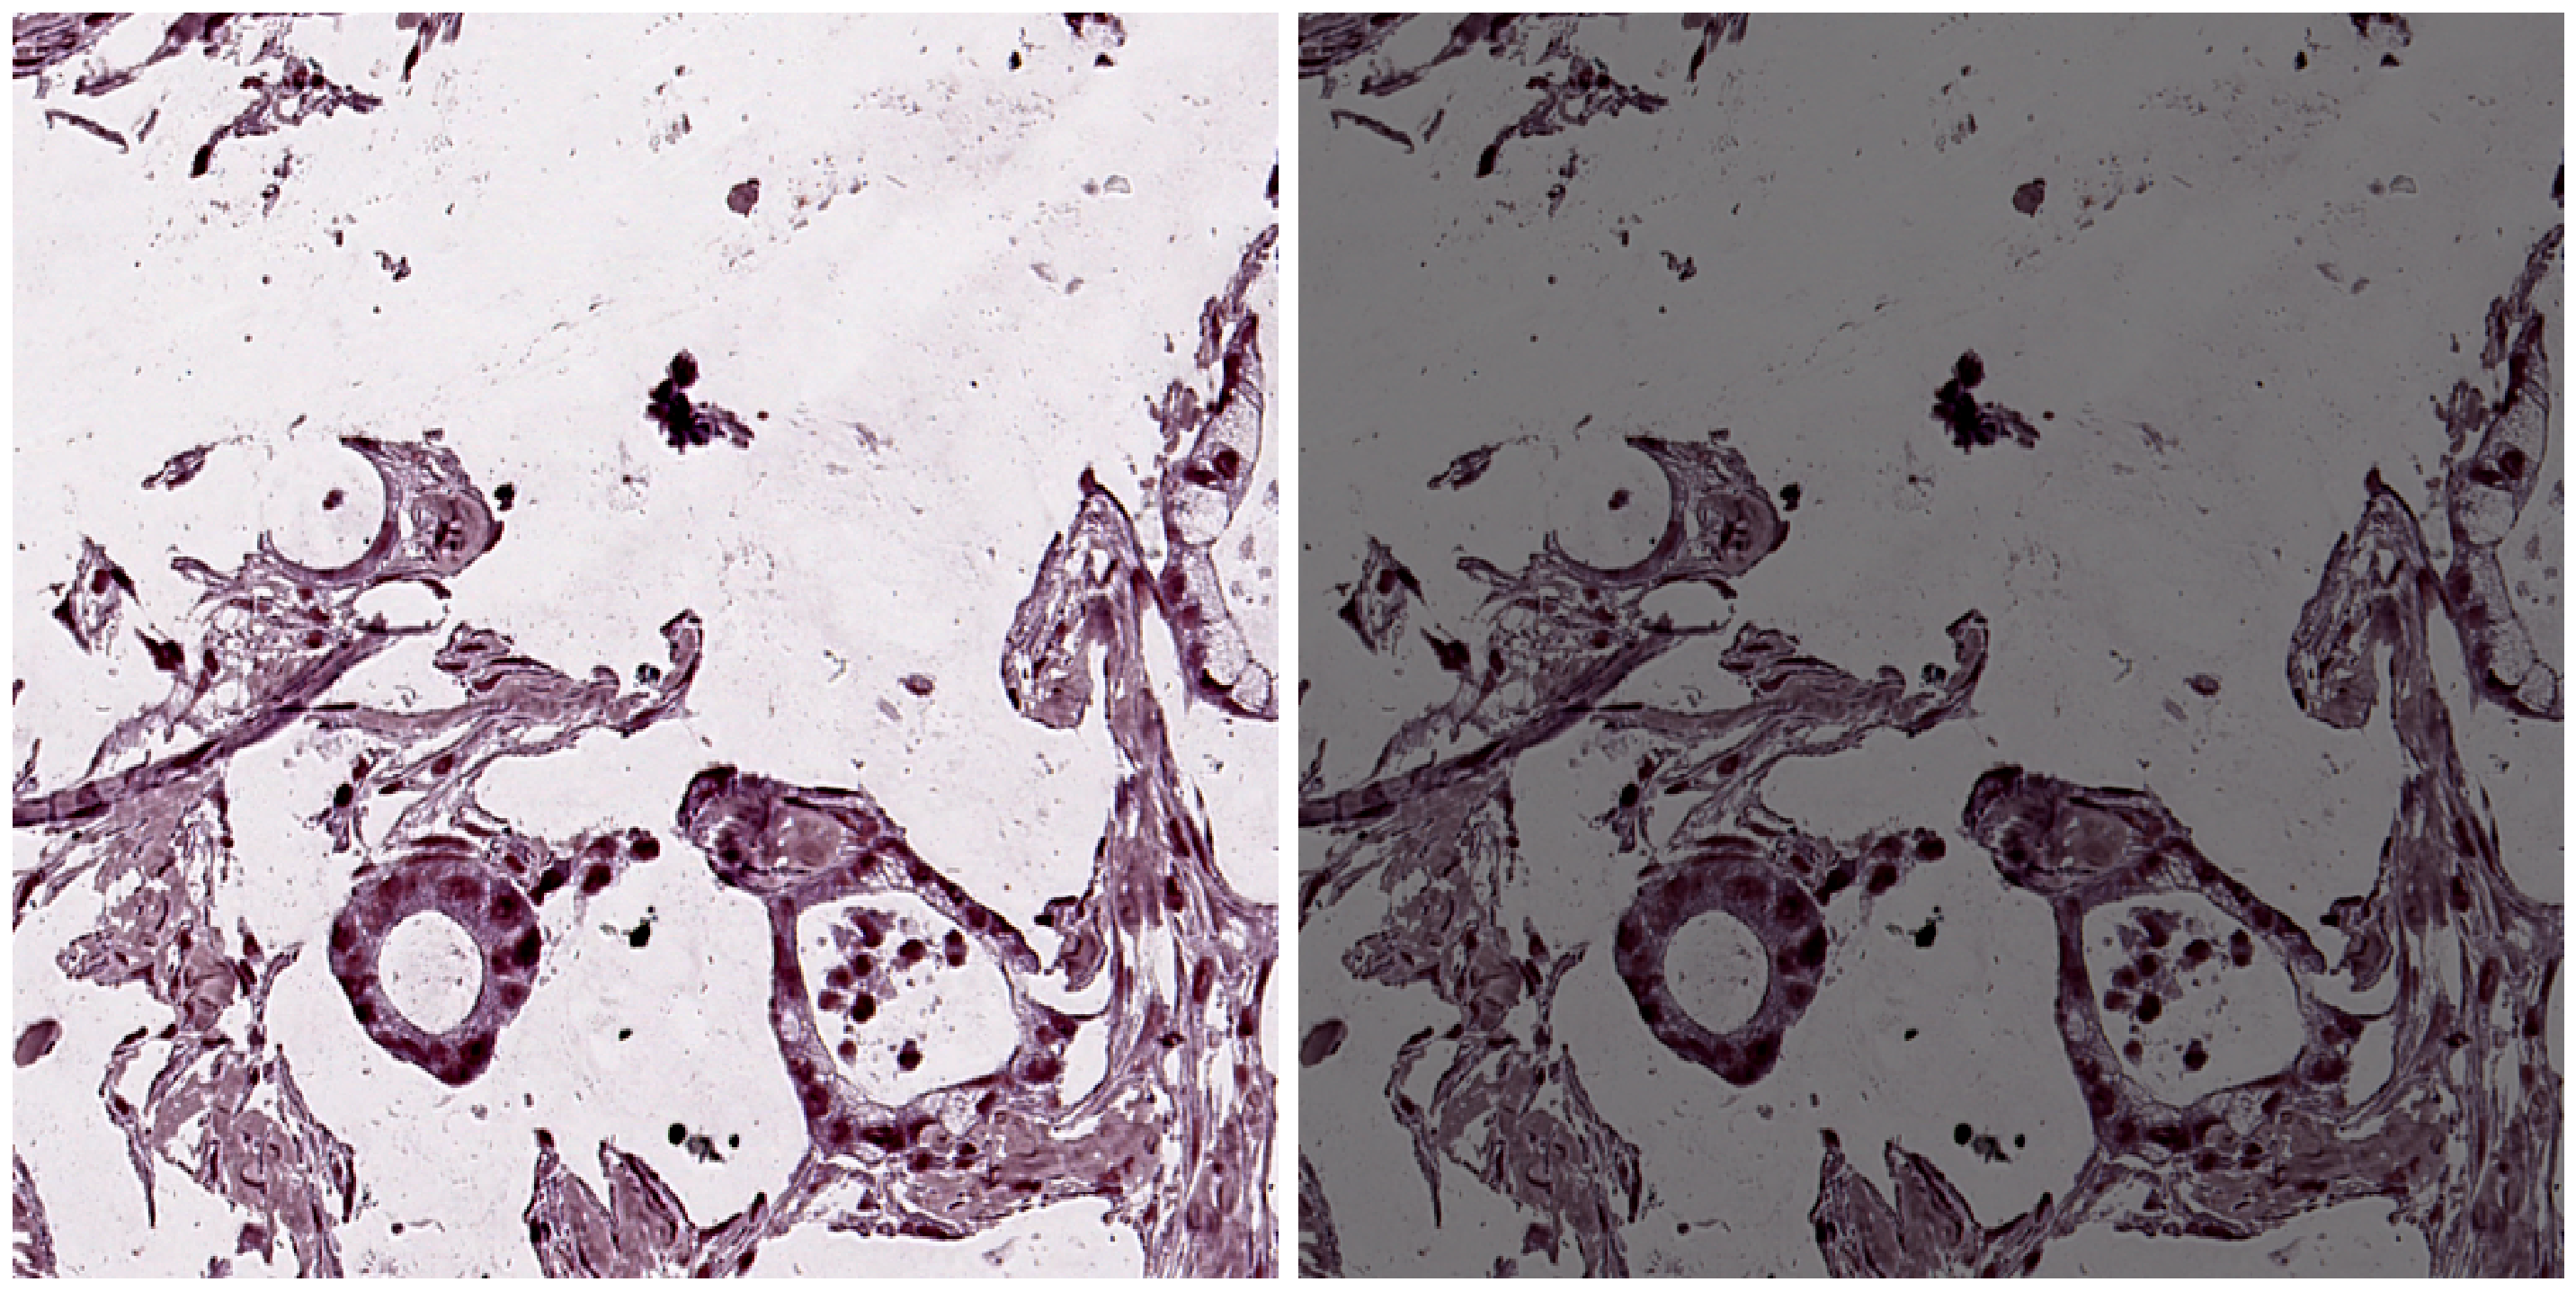

In [75]:
example(model, 42)

In [69]:
set(lbl[:,500])

{0, 1}

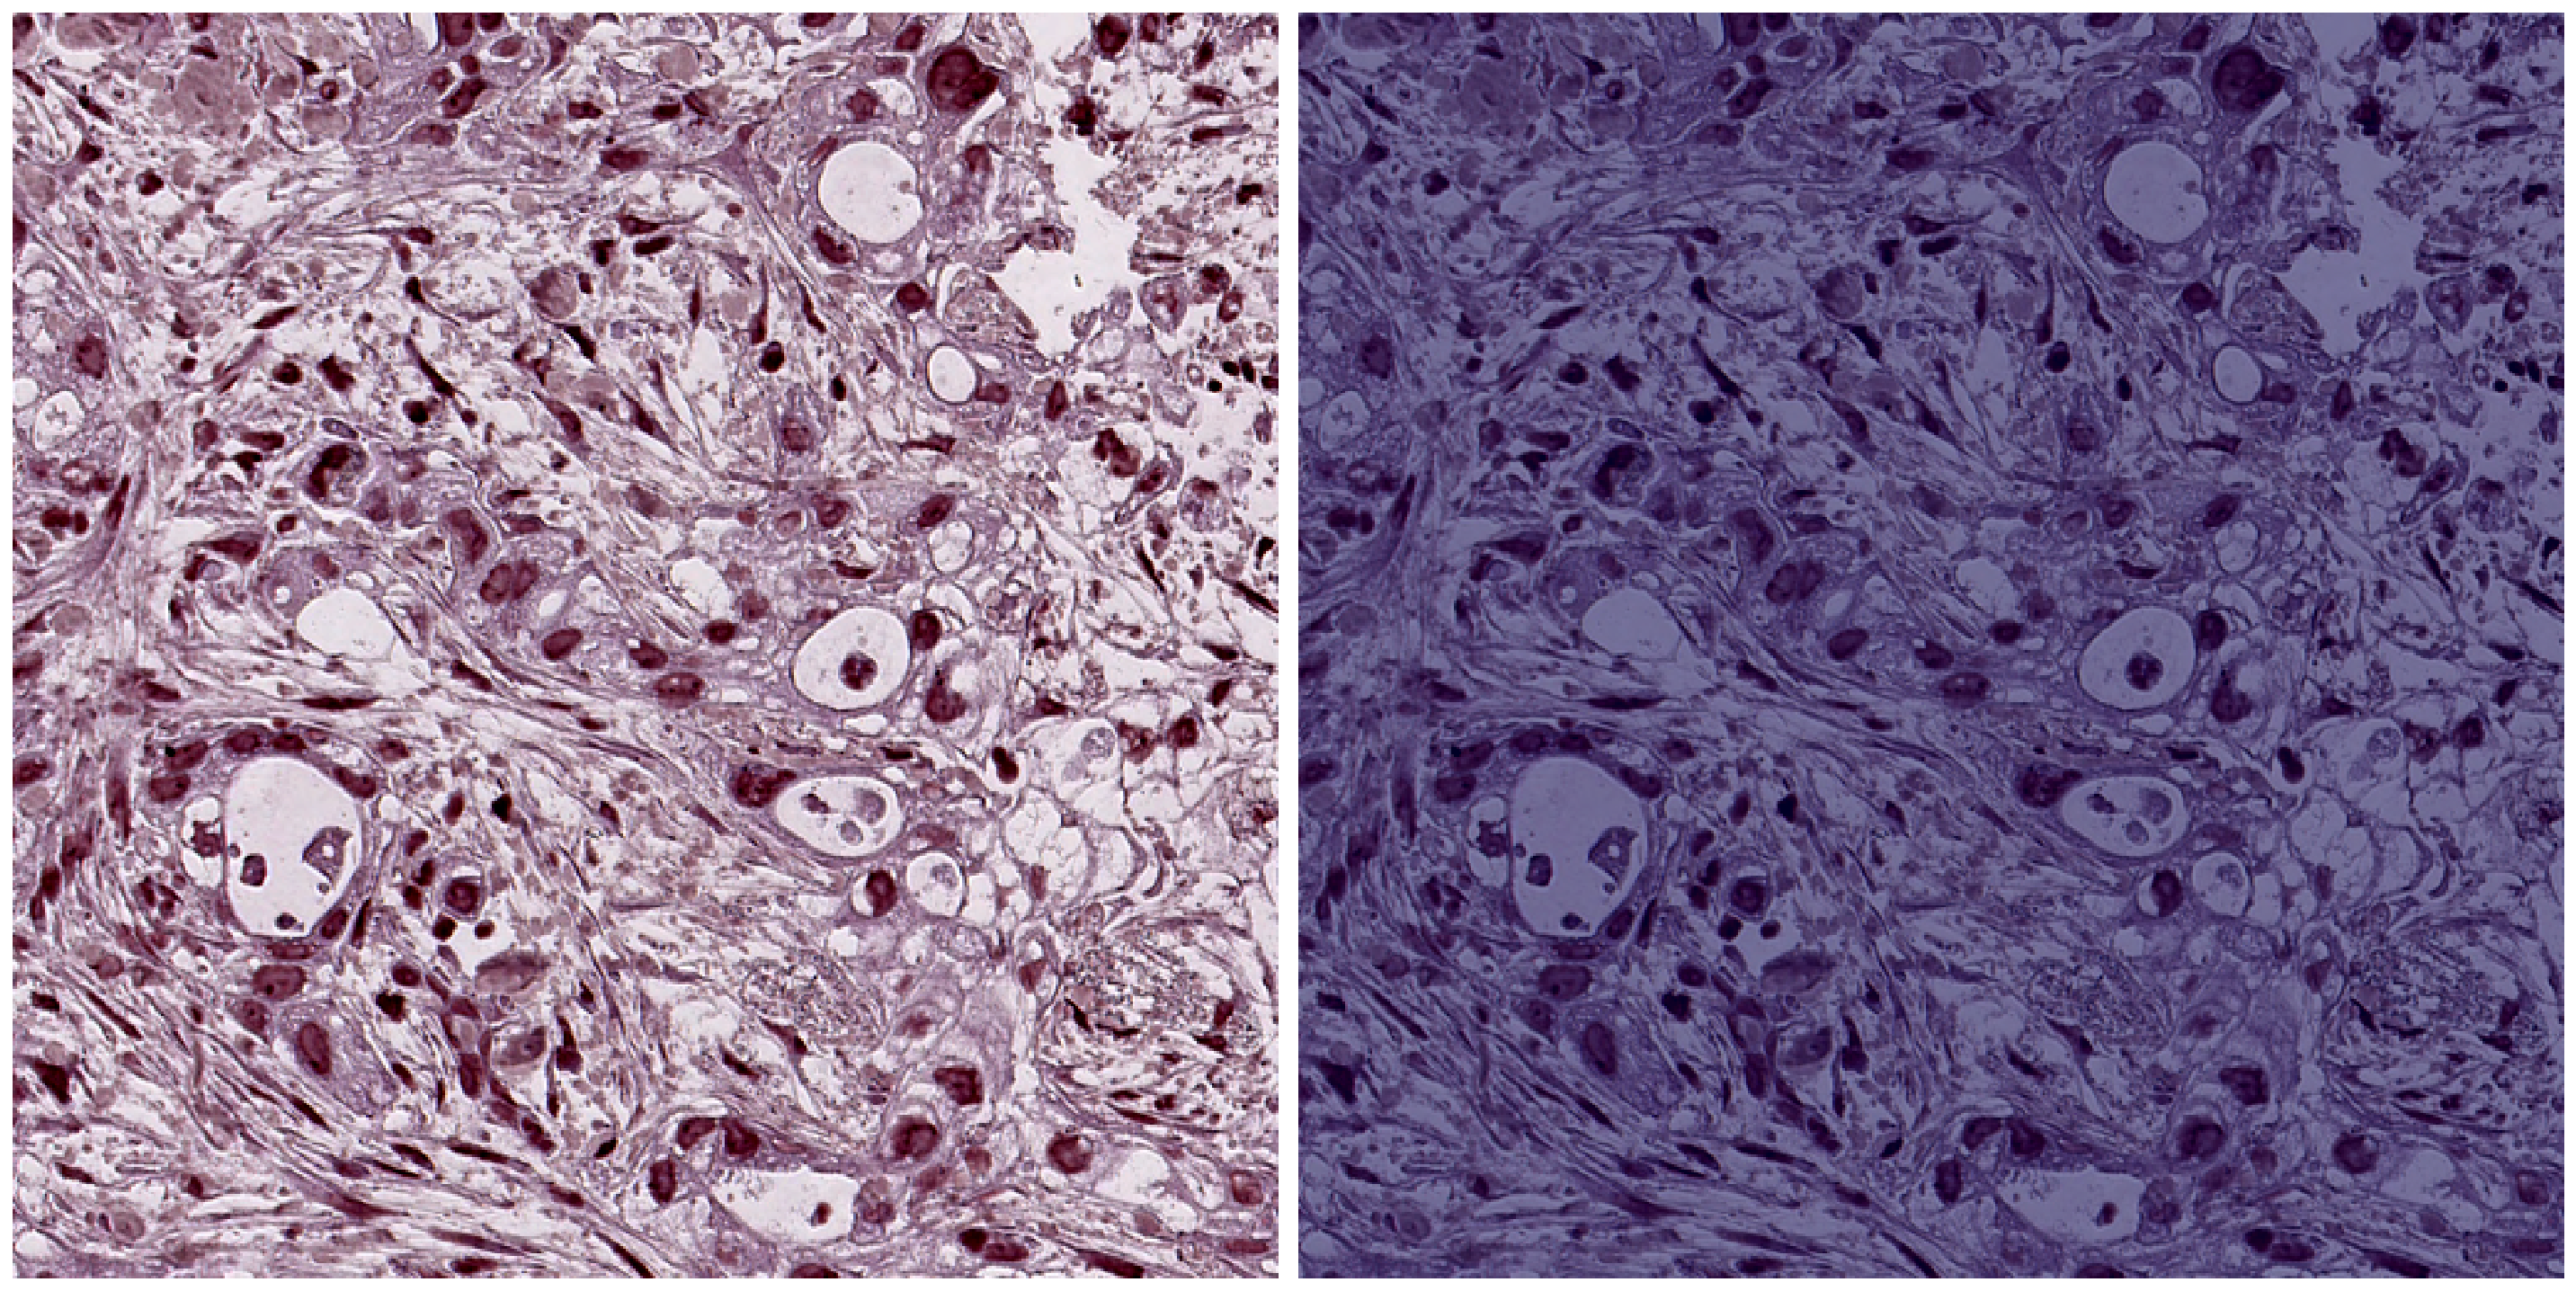

In [66]:
example(model, 15, False)

In [67]:
set(lbl[:,500])

{0, 1}